In [1]:
import sqlite3
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
# import pmdarima as pm
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
lahat_df = pd.read_csv("lahat.csv")

In [3]:
lahat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1115 non-null   int64 
 1   0           1115 non-null   int64 
 2   1           1115 non-null   object
 3   2           1115 non-null   object
dtypes: int64(2), object(2)
memory usage: 35.0+ KB


In [4]:
import re
import ast

def clean_and_eval(s):
    if isinstance(s, dict):
        return s
    if isinstance(s, str):
        # remove np.float64(...) wrappers
        s = re.sub(r'np\.float64\(([^)]+)\)', r'\1', s)
        try:
            return ast.literal_eval(s)
        except Exception:
            return None
    return None

lahat_df['1'] = lahat_df['1'].apply(clean_and_eval)

df_out = pd.json_normalize(lahat_df['1'])
df_out.insert(0, 'Store', lahat_df['0'])

df_out.head()


,Store,TAE,RMSE,MAPE,AIC,BIC
0,1,14997.556215,598.604758,0.104052,14089.266255,14247.450638
1,2,5073.978907,769.167097,0.109097,14363.809902,14521.994284
2,3,4351.068662,917.925883,0.097886,15034.330745,15192.515128
3,4,1297.402050,903.142306,0.077430,15358.993096,15517.177479
4,5,4836.545721,541.721969,0.096720,14429.832527,14588.016910


In [5]:
# Connect to database
conn = sqlite3.connect('rossmann.db')
cursor = conn.cursor()

# Print table names
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('rossmann',)]


In [6]:
# Assign 'rossmann' table to Pandas DataFrame
sql = "SELECT * FROM rossmann"
df = pd.read_sql(sql, conn)

In [7]:
# Used for easier time series analysis
indexed_df = df.copy()
indexed_df['Date'] = pd.to_datetime(df['Date'])
indexed_df = indexed_df.set_index('Date')
indexed_df = indexed_df.sort_index()

In [8]:
import re

all_forecasts = []

for i, text in enumerate(lahat_df['2']):
    matches = re.findall(r'(\d{4}-\d{2}-\d{2})\s+([-+]?\d*\.?\d+)', str(text))
    if not matches:
        continue
    df_temp = pd.DataFrame(matches, columns=['Date', 'Value'])
    df_temp['Date'] = pd.to_datetime(df_temp['Date'])
    df_temp['Value'] = df_temp['Value'].astype(float)
    df_temp['Store'] = lahat_df.loc[i, '0']  # add store ID
    all_forecasts.append(df_temp)

df_all_forecasts = pd.concat(all_forecasts, ignore_index=True)
df_all_forecasts = df_all_forecasts.set_index(['Store', 'Date']).sort_index()

df_all_forecasts.head()


Value
Store Date                   
1     2015-06-20  4195.081759
      2015-06-21  -653.558204
      2015-06-22  3859.639607
      2015-06-23  3348.483798
      2015-06-24  3138.107105

In [9]:
# ensure indexed_df has Store as column and Date as datetime
sales_df = indexed_df.reset_index()[['Store', 'Date', 'Sales']]

# merge forecasts with actual sales
merged = pd.merge(
    df_all_forecasts.reset_index(),   # Store, Date, Value
    sales_df,                         # Store, Date, Sales
    on=['Store', 'Date'],
    how='left'
)

# optional: rename for clarity and set index
merged = merged.rename(columns={'Value': 'Forecast'})
merged = merged.set_index(['Store', 'Date']).sort_index()

merged.head()


Forecast  Sales
Store Date                          
1     2015-06-20  4195.081759   4097
      2015-06-21  -653.558204      0
      2015-06-22  3859.639607   3846
      2015-06-23  3348.483798   3762
      2015-06-24  3138.107105   3346

In [10]:
# prepare metrics table
metrics_df = df_out.rename(columns={'0': 'Store'})

# merge on Store
final = merged.reset_index().merge(metrics_df, on='Store', how='left')

# optional: reindex for time series use
final = final.set_index(['Store', 'Date']).sort_index()

final.head()


Forecast  Sales           TAE        RMSE      MAPE  \
Store Date                                                                 
1     2015-06-20  4195.081759   4097  14997.556215  598.604758  0.104052   
      2015-06-21  -653.558204      0  14997.556215  598.604758  0.104052   
      2015-06-22  3859.639607   3846  14997.556215  598.604758  0.104052   
      2015-06-23  3348.483798   3762  14997.556215  598.604758  0.104052   
      2015-06-24  3138.107105   3346  14997.556215  598.604758  0.104052   

                           AIC           BIC  
Store Date                                    
1     2015-06-20  14089.266255  14247.450638  
      2015-06-21  14089.266255  14247.450638  
      2015-06-22  14089.266255  14247.450638  
      2015-06-23  14089.266255  14247.450638  
      2015-06-24  14089.266255  14247.450638

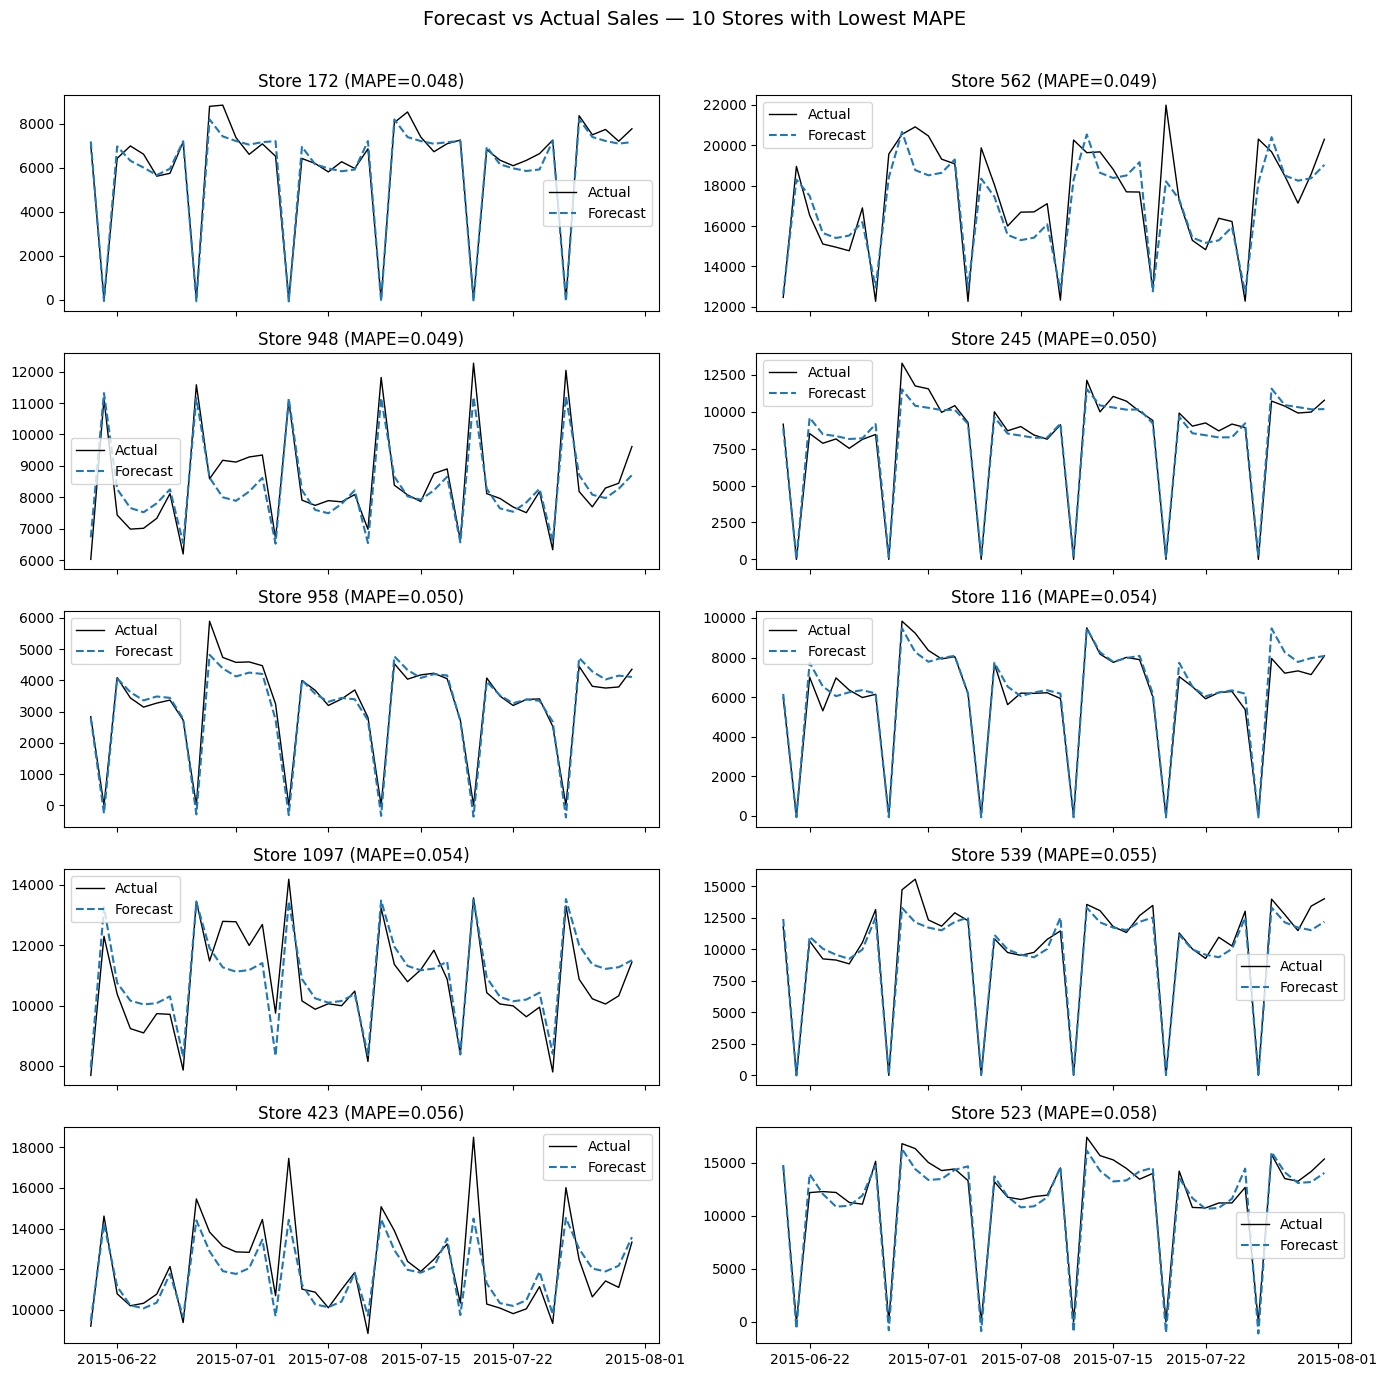

In [11]:
import matplotlib.pyplot as plt

# identify 10 stores with lowest MAPE
lowest_mape_stores = (
    final.reset_index()[['Store', 'MAPE']]
    .drop_duplicates('Store')
    .nsmallest(10, 'MAPE')['Store']
)

# create subplots
fig, axes = plt.subplots(5, 2, figsize=(14, 14), sharex=True)
axes = axes.flatten()

for ax, store in zip(axes, lowest_mape_stores):
    subset = final.loc[store]
    ax.plot(subset.index, subset['Sales'], label='Actual', color='black', linewidth=1)
    ax.plot(subset.index, subset['Forecast'], label='Forecast', color='tab:blue', linestyle='--')
    ax.set_title(f"Store {store} (MAPE={subset['MAPE'].iloc[0]:.3f})")
    ax.legend()

for ax in axes[len(lowest_mape_stores):]:
    ax.axis('off')

fig.suptitle("Forecast vs Actual Sales — 10 Stores with Lowest MAPE", fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


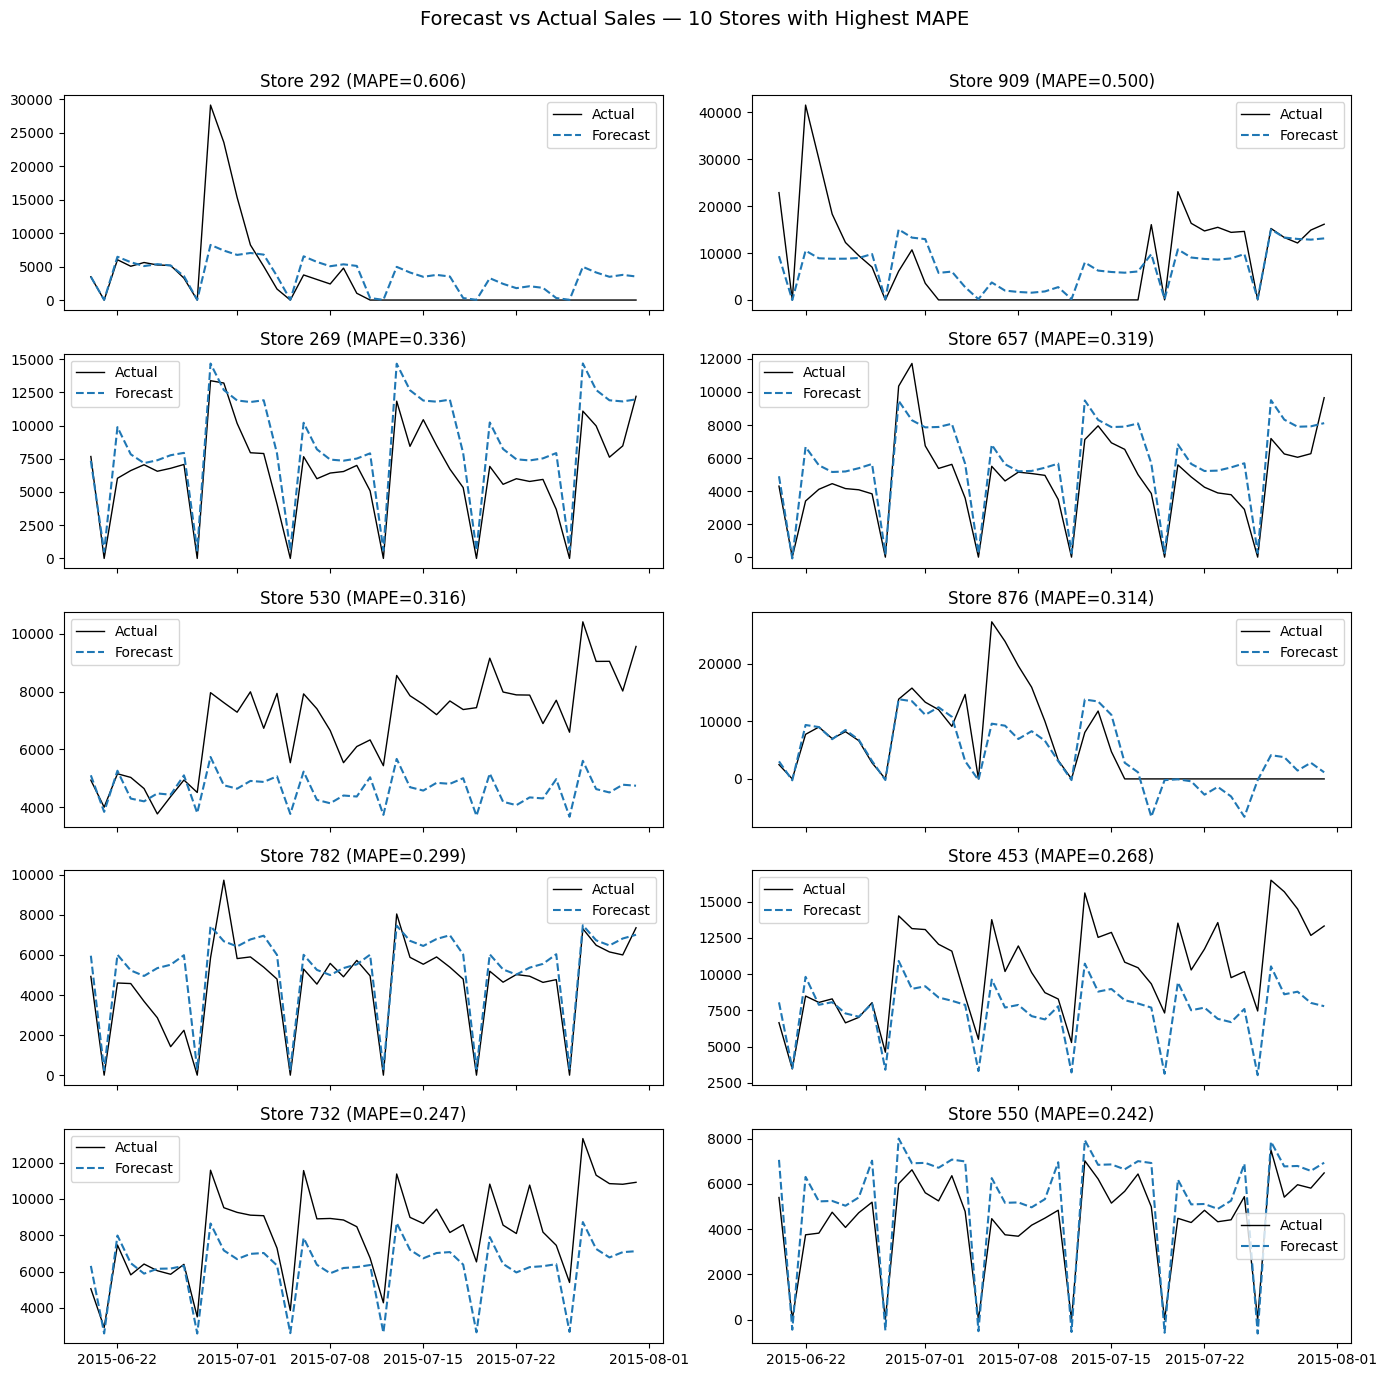

In [18]:
# identify 10 stores with lowest MAPE
lowest_mape_stores = (
    final.reset_index()[['Store', 'MAPE']]
    .drop_duplicates('Store')
    .nlargest(10, 'MAPE')['Store']
)

# create subplots
fig, axes = plt.subplots(5, 2, figsize=(14, 14), sharex=True)
axes = axes.flatten()

for ax, store in zip(axes, lowest_mape_stores):
    subset = final.loc[store]
    ax.plot(subset.index, subset['Sales'], label='Actual', color='black', linewidth=1)
    ax.plot(subset.index, subset['Forecast'], label='Forecast', color='tab:blue', linestyle='--')
    ax.set_title(f"Store {store} (MAPE={subset['MAPE'].iloc[0]:.3f})")
    ax.legend()

for ax in axes[len(lowest_mape_stores):]:
    ax.axis('off')

fig.suptitle("Forecast vs Actual Sales — 10 Stores with Highest MAPE", fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


In [13]:
eps = 1e-9
final['Error'] = final['Sales'] - final['Forecast']
final['AbsErr'] = final['Error'].abs()
final['APE'] = (final['AbsErr'] / (final['Sales'].replace(0, eps))).clip(upper=5)  # guard div/0 and outliers

In [14]:
by_store = final.groupby('Store').agg(
    rows=('Sales','size'),
    sales_sum=('Sales','sum'),
    wape=('AbsErr', lambda x: x.sum() / final.loc[x.index, 'Sales'].sum()),
    bias=('Error','mean'),
    err_std=('Error','std'),
).sort_values('wape')

# attach single-copy metrics (TAE/RMSE/MAPE/AIC/BIC) once per store
metrics_once = (
    final.reset_index()
         .drop_duplicates('Store')[['Store','TAE','RMSE','MAPE','AIC','BIC']]
         .set_index('Store')
)
by_store = by_store.join(metrics_once)
by_store.head()


,rows,sales_sum,wape,bias,err_std,TAE,RMSE,MAPE,AIC,BIC
Store,,,,,,,,,,
948,42,354447,0.049895,112.118134,530.132606,4708.961636,535.648778,0.049457,14415.015319,14573.199701
562,42,726338,0.050772,351.989123,1096.577558,14783.543183,1139.187497,0.048608,15722.290619,15880.475001
172,42,251801,0.050795,117.215112,423.918866,4478.568601,434.934299,0.047751,11434.614071,11592.798453
116,42,253610,0.053757,-154.864676,493.154429,6931.454281,511.266908,0.053897,14406.583866,14564.768248
1097,42,449173,0.053780,-182.364418,706.793225,7659.305568,721.747351,0.054011,14631.065594,14789.249976


In [17]:
summary = pd.DataFrame({
    'WAPE_org': [final['Error'].abs().sum() / final['Sales'].sum()],
    'RMSE_wt': [(by_store['RMSE'] * by_store['sales_sum']).sum() / by_store['sales_sum'].sum()],
    'MAPE_wt': [(by_store['MAPE'] * by_store['sales_sum']).sum() / by_store['sales_sum'].sum()],
    'MAPE_unweighted': [by_store['MAPE'].mean()],
    'AIC_mean': [by_store['AIC'].mean()],
    'BIC_mean': [by_store['BIC'].mean()],
})
summary


,WAPE_org,RMSE_wt,MAPE_wt,MAPE_unweighted,AIC_mean,BIC_mean
0,0.113172,998.396021,0.106729,0.108456,14347.757528,14505.941878


### **Organization-Level Model Evaluation**

The **organization-level summary** shows a **well-calibrated forecasting model** with strong overall performance.  

- **WAPE:** `0.113` → Total forecast error is about **11% of total sales value**, a very good result for retail data.  
- **Weighted RMSE:** `≈ 1,000 EUR` → On an average day, forecasts deviate by roughly **1 k EUR per store**.  
- **MAPE (weighted/unweighted):** `0.107 vs 0.108` → Nearly identical, showing **consistent accuracy across stores** with no skew toward large or small outlets.  
- **AIC ≈ 14,348** and **BIC ≈ 14,506** → Indicate **balanced model complexity**, suggesting the model is neither **overfitted** nor **underparameterized**.  

**Overall:**  
The model **generalizes well**, delivers **stable accuracy** across all stores, and provides a **reliable forecasting baseline**.  
To achieve further improvement, **WAPE** would need to drop below **~10%** or **RMSE** below **~1,000 EUR** to produce a **meaningful business gain**.
